In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors, KDTree
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import joblib

In [ ]:
anime = pd.read_csv('drive/MyDrive/data/Anime_2022.csv')
anime.head(1)
animeb = anime[['ID','Title', 'English', 'Type', 'Episodes', 'Start_Aired','Studios', 'Source', 'Genres', 'Themes', 'Demographics', 'Duration_Minutes', 'Rating', 'Score', 'Popularity', 'Favorites']]
anime.head(1)
# animeb.isna().sum()
anime.Source.value_counts(), anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21460 entries, 0 to 21459
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                21460 non-null  int64  
 1   Title             21460 non-null  object 
 2   Synonyms          21460 non-null  object 
 3   Japanese          21460 non-null  object 
 4   English           21460 non-null  object 
 5   Synopsis          21460 non-null  object 
 6   Type              21460 non-null  object 
 7   Episodes          20913 non-null  float64
 8   Status            21460 non-null  object 
 9   Start_Aired       21460 non-null  object 
 10  End_Aired         21460 non-null  object 
 11  Premiered         21460 non-null  object 
 12  Broadcast         21460 non-null  object 
 13  Producers         21460 non-null  object 
 14  Licensors         21460 non-null  object 
 15  Studios           21460 non-null  object 
 16  Source            21460 non-null  object

(Original        7324
 Manga           4408
 Unknown         3602
 Visual novel    1093
 Game            1059
 Light novel      898
 Other            849
 Novel            634
 Music            357
 Web manga        352
 4-koma manga     306
 Picture book     184
 Book             156
 Mixed media      111
 Card game         65
 Web novel         49
 Radio             13
 Name: Source, dtype: int64, None)

In [ ]:
urls = []
for id in anime['ID']:
    urls.append(f'https://myanimelist.net/anime/{id}')

    # NEXT 3 CELLS ARE JUST FOR SCRAPING AND VERIFYING THE IMAGE URLS FROM MYANIMELIST.COM

In [ ]:
# import requests
# import concurrent.futures
# from bs4 import BeautifulSoup


# max_threads = 5

# urls = urls[19000:]     #ab 14000 se 15000 krna h and upr se cells ko phirse run krna
# Id = []                    # sb phirse krna padega :(
# images = []

# for url in urls:
#     res = requests.get(url)
#     soup = BeautifulSoup(res.content, "html.parser")
#     img = soup.find(id='content').select('img')[0].get('data-src')
#     images.append(img)




# # with concurrent.futures.ThreadPoolExecutor(max_workers=max_threads) as executor:
# #         executor.map(download_url, urls)


# urls


In [ ]:

# old_img = joblib.load('drive/MyDrive/imagelinks.sav')
# images = old_img+images
# joblib.dump(images, 'drive/MyDrive/imagelinks.sav')

# len(images)

# 7 se 8 phir se kr

In [ ]:
# images[20111], anime['ID'][20111]
images = joblib.load('drive/MyDrive/imagelinks.sav')
anime['Image_link'] = images[:21460]
len(images)

21518

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'Episodes'}>],
       [<Axes: title={'center': 'Duration_Minutes'}>,
        <Axes: title={'center': 'Score'}>],
       [<Axes: title={'center': 'Popularity'}>,
        <Axes: title={'center': 'Favorites'}>]], dtype=object)

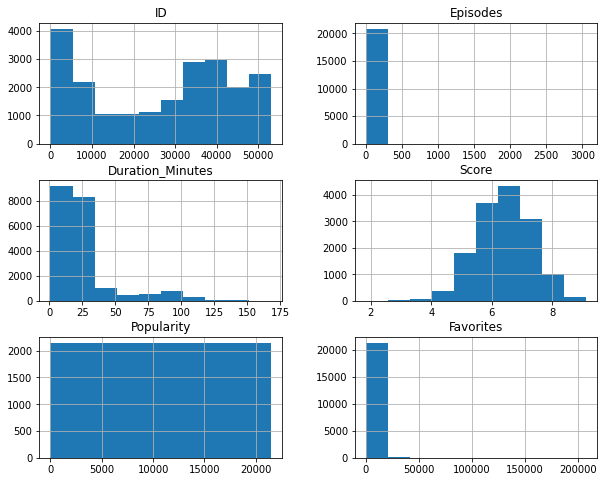

In [ ]:
animeb.hist(figsize=(10,8))

In [ ]:
len(animeb.Studios.value_counts().index.tolist())
animeb.Studios.value_counts()[1:26].sum()
# animeb.Studios.value_counts()

5833

In [ ]:
animeb['Source'].value_counts()

Original        7324
Manga           4408
Unknown         3602
Visual novel    1093
Game            1059
Light novel      898
Other            849
Novel            634
Music            357
Web manga        352
4-koma manga     306
Picture book     184
Book             156
Mixed media      111
Card game         65
Web novel         49
Radio             13
Name: Source, dtype: int64

In [ ]:
#NOW WE ARE REPLACING UNKNOWN VALAUES IN 'ENGLISH' WITH THIER CORRESPONDING TITLES
animeb['Studios'].value_counts()[:20].sum()
(animeb['Title']=='Unknown').value_counts()
animeb.English[anime['English']=='Unknown'] = animeb['Title']
anime.English[anime['English']=='Unknown'] = anime['Title']

#Since we dont want the music type of anime, we shall remove those records
animeb = animeb[animeb.Type!='Music']

#We also have some records which areof 'Type' special, OVA, ONA, or UNKNOWN, I am replacing all such categories
#with OVA only.
animeb.Type = animeb.Type.replace({'Special':'OVA', 'Unknown':'OVA'})
anime.Type = anime.Type.replace({'Unknown':'OVA'})
anime = anime[anime.Type!='Music']

# To fill the NaN values of episode I have used forward fill strategy, which replaces all NaN values
# with the previous not NaN values of the column
animeb.Episodes.ffill( inplace = True)


# since duration of anime series and movies varies drastically in our records I though that we should consider no. of
# episodes as one of the feature, below i have converted episodes into 6 categories:
# very short, short, normal, long, very long, and Huge.
anime.Episodes.value_counts()[:100]
animeb.Episodes = animeb.Episodes//5 * 5
animeb.Episodes[animeb.Episodes>5] = animeb.Episodes//25 * 25
animeb.Episodes[animeb['Episodes']>=100] = 200
animeb.Episodes.replace({0:'Very Short', 5:'Short', 25:'Normal', 50:'Long', 75:'Very Long', 200:'Huge'}, inplace=True)        # 0, 5, 25, 50, 75, 200


# As an Anime head I know that studios can be one of the crucial factors in recommending similar anime.
# Below
top_25 = animeb['Studios'].value_counts()[1:26].index.tolist()
top_25
animeb.Studios[animeb['Studios'].isin(top_25)==False] = 'Others'
animeb['Studios'].iloc[2000:2500].tolist()
animeb.head(3)


animeb.Source[animeb.Source=='Others'] = 'Other'
top_7 = animeb.Source.value_counts()[:7].index.tolist()
animeb.Source[animeb.Source.isin(top_7)==False] = 'UnK'
animeb.head(1)

# Here I am dividing the animes in three categories (retro, New, Recent) according to their 'Start_Aired' values
animeb.Start_Aired[animeb['Start_Aired']=='Unknown'] = '2000'
animeb['Start_Aired'].value_counts()
animeb.Start_Aired[animeb['Start_Aired'].str[-2:].astype(int)>25] = '2005'
animeb.Start_Aired[animeb['Start_Aired'].str[-2:].astype(int)<=5] = '2005'
animeb.Start_Aired[(animeb['Start_Aired'].str[-2:].astype(int)<=15) & (animeb['Start_Aired'].str[-2:].astype(int)>5)] = '2015'
animeb.Start_Aired[animeb['Start_Aired'].str[-2:].astype(int)>15] = '2020'


<ipython-input-37-08ed6a83d0ce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animeb.English[anime['English']=='Unknown'] = animeb['Title']
<ipython-input-37-08ed6a83d0ce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime.English[anime['English']=='Unknown'] = anime['Title']
<ipython-input-37-08ed6a83d0ce>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animeb.Type = an

In [ ]:
animeb.Start_Aired.replace({'2005':'Retro', '2015':'New', '2020':'Recent'}, inplace = True)
# animeb.Start_Aired.value_counts()
animeb.Source[animeb['Source']=='UnK']='Unknown'
# animeb.Source.value_counts()



animeb = animeb.drop('Demographics', axis = 1)
rating_counts = animeb.Rating.value_counts()
type_counts = animeb.Type.value_counts()
episodes_counts = animeb.Episodes.value_counts()
start_aired_counts = animeb.Start_Aired.value_counts()
studio_counts = animeb.Studios.value_counts()
source_counts = animeb.Source.value_counts()
# demographics_counts = animeb.Demographics.value_counts()

def print_all_value_counts():
    print(rating_counts, type_counts, episodes_counts, start_aired_counts, studio_counts, source_counts,  sep='\n\n\n')

print_all_value_counts()
# animeb.loc[11242]

PG-13 - Teens 13 or older         7192
G - All Ages                      5375
PG - Children                     2555
Rx - Hentai                       1441
R - 17+ (violence & profanity)    1321
R+ - Mild Nudity                  1006
None                               542
Name: Rating, dtype: int64


OVA      6449
TV       6280
Movie    3900
ONA      2803
Name: Type, dtype: int64


Very Short    15110
Normal         1886
Long           1021
Short           917
Huge            371
Very Long       127
Name: Episodes, dtype: int64


Retro     7070
New       6522
Recent    5840
Name: Start_Aired, dtype: int64


Others                            13676
Toei Animation                      809
Sunrise                             507
J.C.Staff                           375
Shanghai Animation Film Studio      324
Madhouse                            320
TMS Entertainment                   308
Studio Deen                         276
Production I.G                      254
Pierrot                  

<ipython-input-38-5f4da8a8d3ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animeb.Source[animeb['Source']=='UnK']='Unknown'


In [ ]:
animeb.rename({'English':'English_Title' }, axis =1, inplace = True)
animeb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19432 entries, 0 to 21459
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19432 non-null  int64  
 1   Title             19432 non-null  object 
 2   English_Title     19432 non-null  object 
 3   Type              19432 non-null  object 
 4   Episodes          19432 non-null  object 
 5   Start_Aired       19432 non-null  object 
 6   Studios           19432 non-null  object 
 7   Source            19432 non-null  object 
 8   Genres            19432 non-null  object 
 9   Themes            19432 non-null  object 
 10  Duration_Minutes  18837 non-null  float64
 11  Rating            19432 non-null  object 
 12  Score             13363 non-null  float64
 13  Popularity        19432 non-null  int64  
 14  Favorites         19432 non-null  int64  
dtypes: float64(2), int64(3), object(10)
memory usage: 2.4+ MB


In [ ]:
# Genres and Themes are most import features so

animeb.Genres.replace({'Unknown':'Unk_Genre'}, inplace=True)
animeb.Themes.replace({'Unknown':'Unk_Theme'}, inplace=True)


animeb.Genres = [[val.strip() for val in sublist] for sublist in animeb['Genres'].str.split(',')]
animeb.Themes = [[val.strip() for val in sublist] for sublist in animeb.Themes.str.split(',')]

gen = animeb.Genres.explode().value_counts()
themes = animeb.Themes.explode().value_counts()

In [ ]:
print(gen, themes, sep='\n')
# gen.shape+themes.shape


Comedy           6630
Action           4295
Fantasy          4126
Adventure        3430
Sci-Fi           2804
Drama            2704
Unk_Genre        2166
Slice of Life    1934
Romance          1923
Supernatural     1525
Hentai           1452
Ecchi             775
Mystery           772
Sports            705
Avant Garde       520
Horror            489
Suspense          183
Boys Love         156
Gourmet           115
Girls Love        103
Erotica            41
Award Winning      14
Name: Genres, dtype: int64
Unk_Theme            9620
School               1769
Historical           1345
Mecha                1187
Music                 883
Parody                683
Military              635
Super Power           601
Mythology             553
Martial Arts          521
Space                 490
Harem                 380
Psychological         372
Anthropomorphic       341
Adult Cast            307
Strategy Game         297
Team Sports           289
Detective             258
Isekai               

In [ ]:

TfidfVectorizer(analyzer=set).fit_transform(animeb.Genres+animeb.Themes).toarray().shape

(19432, 73)

In [ ]:
animeb['Genre_Themes'] = animeb.Genres+animeb.Themes
# cv = CountVectorizer(analyzer = set)
# cv.fit_transform(animeb['Genre_Themes'])
animeb.drop(['Genres', 'Themes'], axis = 1, inplace=True)


In [ ]:
animeb['Rating'].value_counts()

PG-13 - Teens 13 or older         7192
G - All Ages                      5375
PG - Children                     2555
Rx - Hentai                       1441
R - 17+ (violence & profanity)    1321
R+ - Mild Nudity                  1006
None                               542
Name: Rating, dtype: int64

In [ ]:
s = animeb.Genre_Themes.explode()
# animeb.join(pd.crosstab(s.index, s)).info()


In [ ]:

animeb.head(5)

,ID,Title,English_Title,Type,Episodes,Start_Aired,Studios,Source,Duration_Minutes,Rating,Score,Popularity,Favorites,Genre_Themes
0,16498,Shingeki no Kyojin,Attack on Titan,TV,Normal,New,Others,Manga,24.0,R - 17+ (violence & profanity),8.531,1,155695,"[Action, Drama, Gore, Military, Survival]"
1,1535,Death Note,Death Note,TV,Normal,New,Madhouse,Manga,23.0,R - 17+ (violence & profanity),8.621,2,159701,"[Supernatural, Suspense, Mystery, Psychologica..."
2,5114,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist Brotherhood,TV,Long,New,Bones,Manga,24.0,R - 17+ (violence & profanity),9.131,3,207772,"[Action, Adventure, Drama, Fantasy, Military]"
3,30276,One Punch Man,One Punch Man,TV,Very Short,New,Madhouse,Unknown,24.0,R - 17+ (violence & profanity),8.511,4,59651,"[Action, Comedy, Parody, Super Power]"
4,11757,Sword Art Online,Sword Art Online,TV,Normal,New,A-1 Pictures,Light novel,23.0,PG-13 - Teens 13 or older,7.201,5,64997,"[Action, Adventure, Fantasy, Romance, Love Pol..."


In [ ]:
num_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
                ('ordinal_encoder', OrdinalEncoder()),
                ('simple_imputer', SimpleImputer(strategy='most_frequent')),
                ('categorical_encoder', OneHotEncoder()),
])



list_pipeline = Pipeline([
                ('count_vectoriser', CountVectorizer(analyzer=set)),

])
animeb.head()




preprocess_pipeline = ColumnTransformer([
                        ('num_columns',num_pipeline, ['Duration_Minutes', 'Score']),
                        ('cat_columns', cat_pipeline, ['Type', 'Studios', 'Source', 'Rating','Episodes', 'Start_Aired']),
                        ('list_columns', list_pipeline, 'Genre_Themes'),
])



# For combined predictions above pipeline wasnt working very well, On experimenting with different columns it was found
# that below pipeline is working very well with the Combined Predictions.
preprocess_pipeline_2 = ColumnTransformer([
                            ('num_columns',num_pipeline, ['Score']),
                            ('cat_columns', cat_pipeline, [ 'Type','Episodes', 'Rating']),
                            ('list_columns', list_pipeline, 'Genre_Themes'),
                            ])






animeb = animeb.reset_index()
animeb.drop('index',1, inplace = True)
anime = anime.reset_index()
anime.drop('index',1, inplace  =True)
train = preprocess_pipeline.fit_transform(animeb)
train_combined = preprocess_pipeline_2.fit_transform(animeb)
train_combined.shape
train.shape, train_combined

<ipython-input-47-e7f7fa56602f>:45: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  animeb.drop('index',1, inplace = True)
<ipython-input-47-e7f7fa56602f>:47: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  anime.drop('index',1, inplace  =True)


((19432, 128), <19432x91 sparse matrix of type '<class 'numpy.float64'>'
 	with 138594 stored elements in Compressed Sparse Row format>)

In [ ]:
train.shape
K_model_cos = NearestNeighbors(n_neighbors=100, metric='cosine')
K_model_man2 = NearestNeighbors(n_neighbors=100, metric='l2')
K_model_cos.fit(train)
K_model_man2.fit(train)
K_combined_cos = NearestNeighbors(n_neighbors= 100, metric='cosine' )
K_combined_cos.fit(train_combined)
# K_model_man2.get_params()

NearestNeighbors(metric='cosine', n_neighbors=100)

In [ ]:
#change the anime name in below line it will search in the dataframe with the name and convert that row into vector and
# show nearest neighbors for that Anime (firstly recommendations from cosine metrixs is shown then recomm. with l2 metrics)
sample = train.toarray()[animeb.English_Title[animeb['English_Title'].str.lower().str.contains('attack on titan')].index[0]]
sample
tree = KDTree(train.toarray())
distances_kd, indices_kd = tree.query([sample], k=100)
distances_cos, indices_cos = K_model_cos.kneighbors([sample])
distances_man, indices_man = K_model_man2.kneighbors([sample])
# distances_cos, indices_cos =
cosine_pred = animeb['English_Title'].iloc[indices_cos.squeeze()[0:]].tolist()
man2_pred = animeb['English_Title'].iloc[indices_kd.squeeze()[0:]].tolist()
cosine_preds = animeb[['English_Title','Genre_Themes']].iloc[indices_cos.squeeze()]
man2_preds = animeb[['English_Title','Genre_Themes']].iloc[indices_kd.squeeze()]
cosine_preds
cosine_pred, man2_pred

(['Attack on Titan',
  'Attack on Titan Season 3 Part 2',
  'Attack on Titan The Final Season',
  'Attack on Titan The Final Season Part 2',
  'Attack on Titan Season 3',
  'Attack on Titan Season 2',
  'Kingdom Season 4',
  'Kingdom Season 3',
  'Attack on Titan OAD',
  'Kingdom Season 2',
  'The Heroic Legend of Arslan',
  'Mazinger Edition Z The Impact!',
  'Kingdom',
  'Fullmetal Alchemist Brotherhood',
  "JoJo's Bizarre Adventure Stardust Crusaders - Battle in Egypt",
  'Code Geass Lelouch of the Rebellion R2',
  'Seraph of the End Battle in Nagoya',
  "JoJo's Bizarre Adventure Golden Wind",
  'Demon Slayer Kimetsu no Yaiba',
  "JoJo's Bizarre Adventure",
  'Attack on Titan Since That Day',
  'Initial D First Stage',
  "JoJo's Bizarre Adventure Diamond is Unbreakable",
  'Seraph of the End Vampire Reign',
  "JoJo's Bizarre Adventure Stardust Crusaders",
  'Vinland Saga',
  'Major S3',
  'Code Geass Lelouch of the Rebellion',
  'Banana Fish',
  'Rainbow',
  'Initial D Fifth Stage',

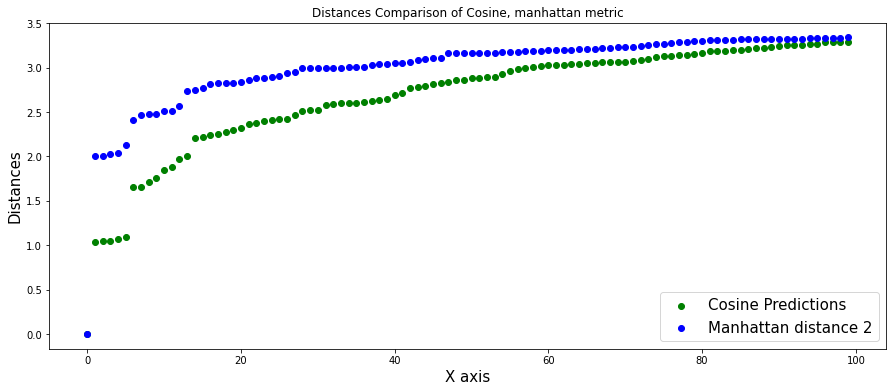

In [ ]:
plt.figure(figsize=(15,6))
X = np.arange(0, 100, 1)
plt.scatter(X ,distances_cos.squeeze()*10, c='g')
plt.scatter(X, distances_man.squeeze(), c='b')

plt.title('Distances Comparison of Cosine, manhattan metric')
plt.xlabel('X axis',fontsize=15)
plt.ylabel('Distances',fontsize=15)
plt.legend(['Cosine Predictions', 'Manhattan distance 2'], fontsize=15)

plt.show()

In [ ]:
input = ['to love ru', 'high school dxd']
import json
import joblib
animec = animeb.copy()
 # I have used this to check the max. RAM usage that is taken by the system
                                         # during the process of Recommending the Anime

# We have to reduce the model file size as we have to use it and load it in thebackend of our website and we would want
# that our model and other important files uses less space so that it can be easily loaded and rapidly proccesed in our
# RAM, so we save our big files with parquet format which is a very compact format , and over that we are zipping it too
# for the anime dataset as it is very large file so it reduces the size by very significant amount.
anime.to_parquet('final_anime_list.parquet', compression='GZIP')
joblib.dump(K_model_cos, 'K_model_cos.sav')
joblib.dump(K_combined_cos, 'K_combined_cos.sav')
joblib.dump(train, 'train.sav')
joblib.dump(train_combined, 'train_combined.sav')
t= joblib.load('train.sav')
tc= joblib.load('train_combined.sav')
kmc = joblib.load('K_model_cos.sav')
kcc = joblib.load('K_combined_cos.sav')
fin_anime = pd.read_parquet('final_anime_list.parquet')

def recommend(input="demon slayer|jujutsu kaisen"): # Input will be separated by '|' and then mid points of the
    input = (input.lower()).split('|')              # corresponding vector representations will be found coresponding to
                                                    # which Final Recommendations will be given as output.
    if len(input)==1:
        sample = t.toarray()[anime.index[anime['English'].str.lower().str.contains(input[0])]][0]
        distances_cos, indices_cos = kmc.kneighbors([sample])
        results = fin_anime.iloc[indices_cos.squeeze()[0:]]
        results.drop(['Japanese'], axis=1, inplace=True)
        results['Distances'] = distances_cos.squeeze()[0:]
        return json.loads(results.to_json(orient='records'))

    else:
        samples=[]
        for name in input:
            samples.append(tc.toarray()[animeb.index[animeb['English_Title'].to_numpy().str.lower().str.contains(name)]][0])
        sample_mean = [sum(sub_list) / len(sub_list) for sub_list in zip(*samples)] # finding mean of all nodes and
        distances_cos_comb, indices_cos_comb = kcc.kneighbors([sample_mean])        # treating it as a midpoint
        results = fin_anime.iloc[indices_cos_comb.squeeze()[0:]]
        results.drop(['Japanese'], axis=1, inplace=True)
        results['Distances'] = distances_cos_comb.squeeze()[0:]
        return json.loads(results.to_json(orient='records'))






NameError: ignored

In [ ]:
results_json = recommend('Demon Slayer|Monster')
!pip install memory-profiler
from memory_profiler import memory_usage
results_df = pd.json_normalize(results_json)
# results_df['English'].tolist()
results_json
results_df['English'].tolist()
max(memory_usage(proc=recommend))

<ipython-input-51-9ee0ca94ffad>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results.drop(['Japanese'], axis=1, inplace=True)
<ipython-input-51-9ee0ca94ffad>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Distances'] = distances_cos_comb.squeeze()[0:]
<ipython-input-51-9ee0ca94ffad>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results.drop(['Japanese'], axis

506.09765625

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.scatter(np.arange(0, 100, 1), distances, c='orange')
# plt.ylabel('Distances', size=20)
# plt.scatter(np.arange(0, 100, 1), distances_combined, c='g')
# plt.legend(['naive', 'updated'], fontsize=15)
# plt.show()
anime[['ID', 'English', 'Type', 'Premiered', 'Image_link']].to_json("anime_list.json", orient="records" )
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19432 entries, 0 to 19431
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19432 non-null  int64  
 1   Title             19432 non-null  object 
 2   Synonyms          19432 non-null  object 
 3   Japanese          19432 non-null  object 
 4   English           19432 non-null  object 
 5   Synopsis          19432 non-null  object 
 6   Type              19432 non-null  object 
 7   Episodes          18891 non-null  float64
 8   Status            19432 non-null  object 
 9   Start_Aired       19432 non-null  object 
 10  End_Aired         19432 non-null  object 
 11  Premiered         19432 non-null  object 
 12  Broadcast         19432 non-null  object 
 13  Producers         19432 non-null  object 
 14  Licensors         19432 non-null  object 
 15  Studios           19432 non-null  object 
 16  Source            19432 non-null  object

In [ ]:
# anime.isna().sum()
# anime[['Duration_Minutes', 'Score', 'Scored_Users', 'Ranked']]
